In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
data_A = pd.read_csv("datasets/DetectorA.csv")
data_B = pd.read_csv("datasets/DetectorB.csv")
data_C = pd.read_csv("datasets/DetectorC.csv")
data_Target = pd.read_csv("datasets/DetectorTarget.csv")


<Axes: title={'center': 'Detector A Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

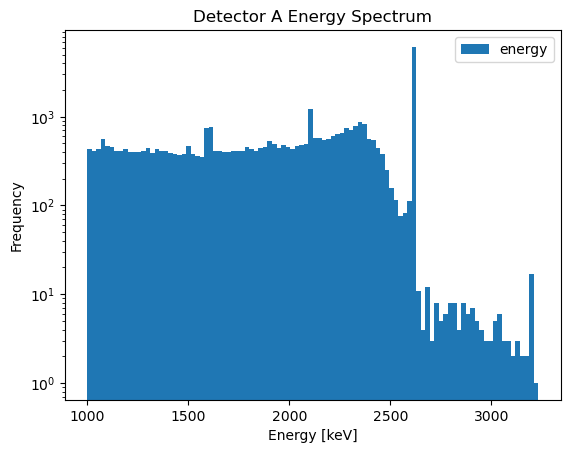

In [3]:
data_A.plot(kind='hist', title='Detector A Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

<Axes: title={'center': 'Detector B Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

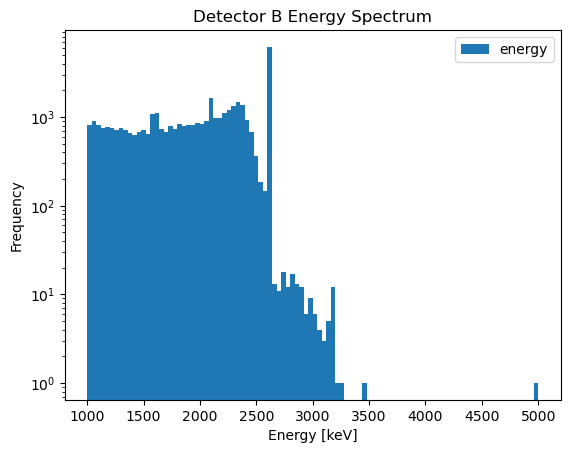

In [4]:
data_B.plot(kind='hist', title='Detector B Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

<Axes: title={'center': 'Detector C Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

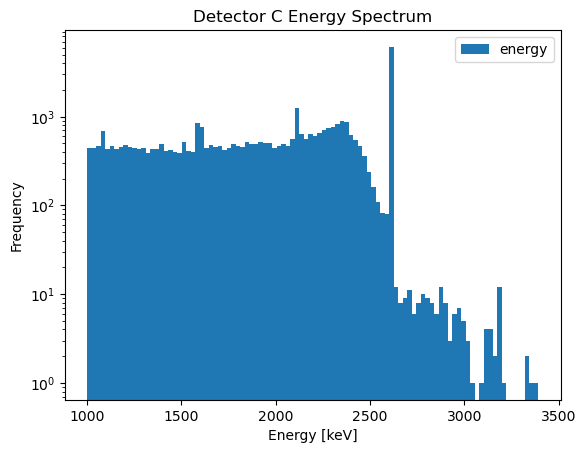

In [5]:
data_C.plot(kind='hist', title='Detector C Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

<Axes: title={'center': 'Detector Target Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

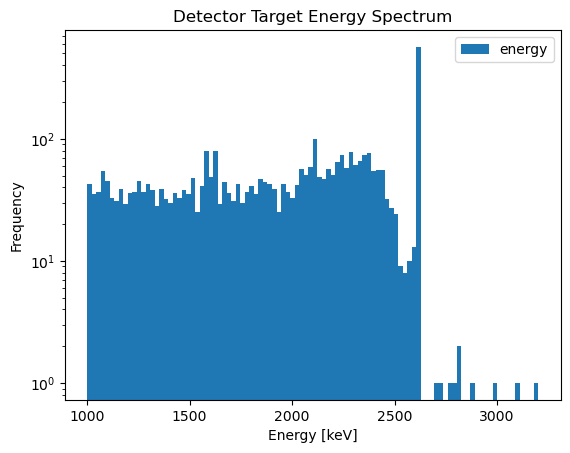

In [6]:
data_Target.plot(kind='hist', title='Detector Target Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

step 2: signal peak cut

In [7]:
def calc_cut_eff(Nc, tau, N, B, Bc):
    eff = (Nc-tau*Bc)/(N-tau*B)
    return eff

In [8]:
signal_window_min= 1590
signal_window_max = 1595

sig_base_window_min = 1585
sig_base_window_max = 1590


energies_A = data_A["energy"]
sig_energy = data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max), 'energy']
base_energy = data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max), 'energy']
N_sig = len(sig_energy)
B_sig = len(base_energy)
tau_sig = 1
sig_scores = data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max), 'cnn_score']
baseline_scores = data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max), 'cnn_score'] 
cut_thresh = .15
Nc_sig= len(data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
Bc_sig = len(data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
cut_eff = calc_cut_eff(Nc_sig, tau_sig, N_sig, B_sig, Bc_sig)
print("True Positive Rate (Cut efficiency)= ", cut_eff)
print(N_sig, B_sig, Nc_sig, Bc_sig)




True Positive Rate (Cut efficiency)=  0.7690217391304348
454 86 329 46


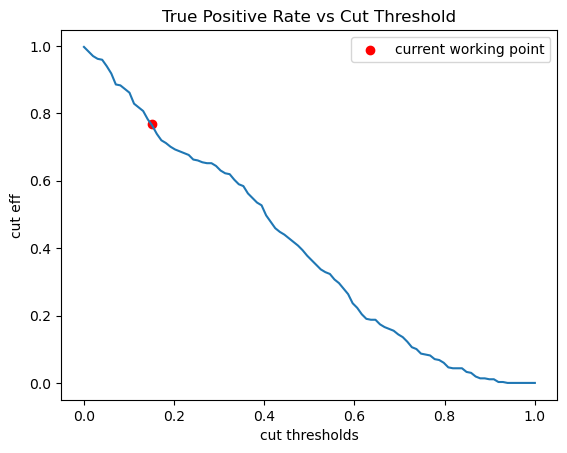

In [9]:

thresholds = np.linspace(0, 1, num=100)
effs = []
for thresh in thresholds:
    Nc= len(data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    Bc = len(data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    eff = calc_cut_eff(Nc, 1, N_sig, B_sig, Bc)
    effs.append(eff)
    
plt.figure()
plt.plot(thresholds, effs)
plt.scatter(.15,0.7690217391304348, label="current working point", color="red")
plt.legend()
plt.xlabel("cut thresholds")
plt.ylabel("cut eff")
plt.title("True Positive Rate vs Cut Threshold")
plt.show()

Step 3: false positive rate for background peak

In [10]:
bkg_window_min= 2098
bkg_window_max = 2108

bkg_base_window_min = 2093
bkg_base_window_max = 2113


energies_A = data_A["energy"]
bkg_energy = data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max), 'energy']
bkg_base_energy_lower = data_A.loc[(data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min), 'energy']
bkg_base_energy_upper = data_A.loc[(data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max), 'energy']

N_bkg = len(bkg_energy)
B_bkg = len(bkg_base_energy_lower) + len(bkg_base_energy_upper)
tau_bkg = 1
bkg_scores = data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max), 'cnn_score']
# bkg_baseline_scores = data_A.loc[((data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min)) or ((data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max)), 'cnn_score'] 
cut_thresh = .15
Nc_bkg= len(data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
Bc_bkg = len(data_A.loc[(data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min) & (data_A['cnn_score']>cut_thresh), 'cnn_score']) + len(data_A.loc[(data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
cut_eff_bkg = calc_cut_eff(Nc_bkg, tau_bkg, N_bkg, B_bkg, Bc_bkg)
print("False Positive Rate (Cut efficiency)= ", cut_eff_bkg)
print(N_bkg, B_bkg, Nc_bkg, Bc_bkg)

False Positive Rate (Cut efficiency)=  0.10058309037900874
933 247 165 96


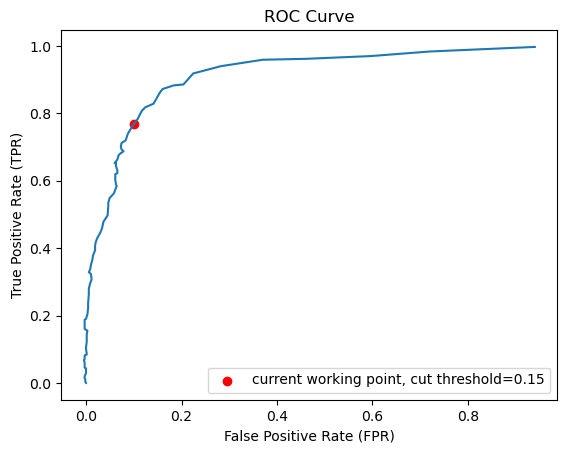

In [11]:
thresholds = np.linspace(0, 1, num=100)
tprs = []
fprs = []
for thresh in thresholds:
    Nc= len(data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    Bc = len(data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    tpr = calc_cut_eff(Nc, 1, N_sig, B_sig, Bc)
    tprs.append(tpr)

    nc_bkg = len(data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max) & (data_A['cnn_score']>thresh), 'cnn_score']) 
    bc_bkg = len(data_A.loc[(data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min) & (data_A['cnn_score']>thresh), 'cnn_score']) + len(data_A.loc[(data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    fpr = calc_cut_eff(nc_bkg, 1, N_bkg, B_bkg, bc_bkg)
    fprs.append(fpr)

    
plt.figure()
plt.plot(fprs, tprs)
plt.scatter(0.10058309037900874, 0.7690217391304348, label="current working point, cut threshold=0.15", color="red")
plt.legend()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.show()

step 4: PDF for NLDBD

In [81]:
E0= 2039
sigma =1

def nldbd_pdf(x):
    return stats.norm.pdf(x, loc=E0, scale=sigma)/np.trapz(stats.norm.pdf(x, loc=E0, scale=sigma),x)

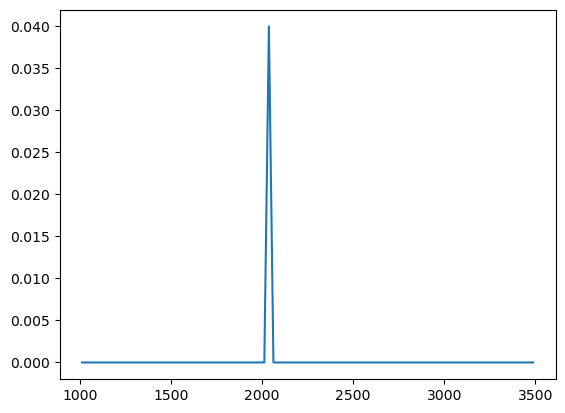

In [82]:
plt.plot(bin_centers, nldbd_pdf(bin_centers))
plt.show()

Step 5: apply the cut

In [13]:
data_A_with_cut = data_A.loc[(data_A['cnn_score']>cut_thresh)]
data_B_with_cut = data_B.loc[(data_B['cnn_score']>cut_thresh)]
data_C_with_cut = data_C.loc[(data_C['cnn_score']>cut_thresh)]
data_Target_with_cut = data_Target.loc[(data_B['cnn_score']>cut_thresh)]


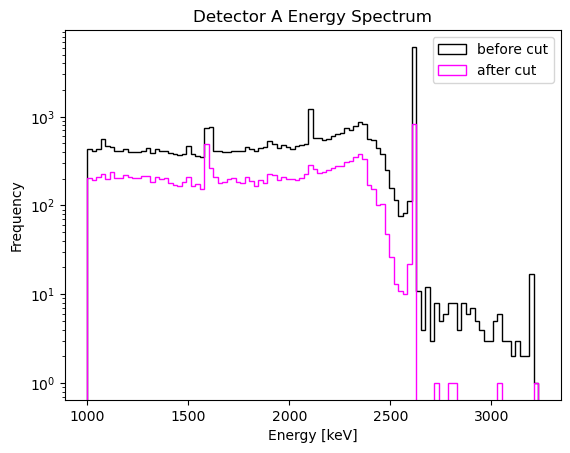

In [14]:
plt.figure()
ax = data_A['energy'].plot(
    kind='hist', 
    title='Detector A Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_A_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

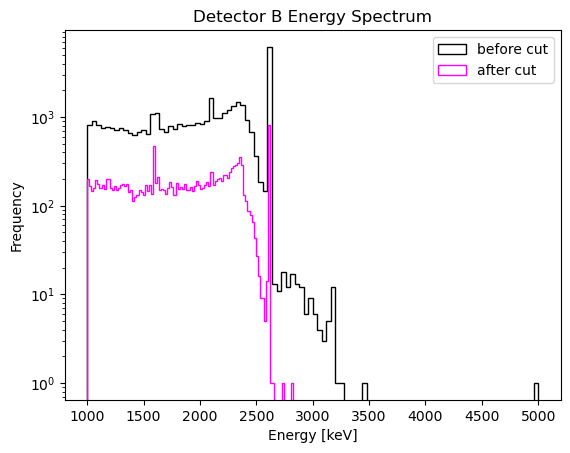

In [15]:
plt.figure()
ax = data_B['energy'].plot(
    kind='hist', 
    title='Detector B Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_B_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

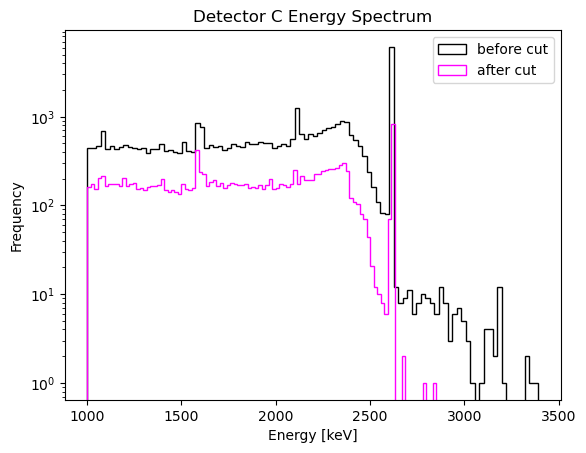

In [16]:
plt.figure()
ax = data_C['energy'].plot(
    kind='hist', 
    title='Detector C Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_C_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

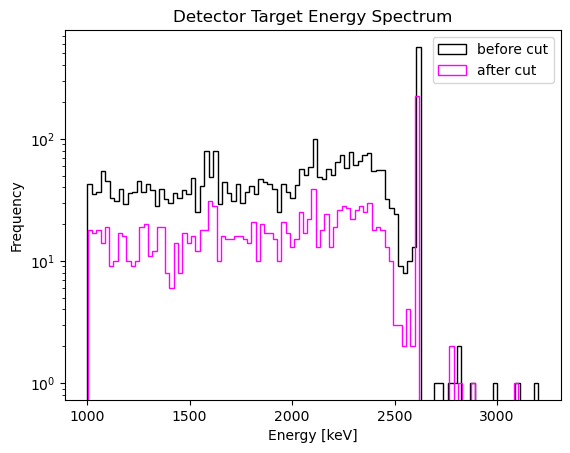

In [17]:
plt.figure()
ax = data_Target['energy'].plot(
    kind='hist', 
    title='Detector Target Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_Target_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

Step 5: PDF for detectors

Step 6: Perform the fit

In [18]:
pip install iminuit --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
from iminuit import Minuit

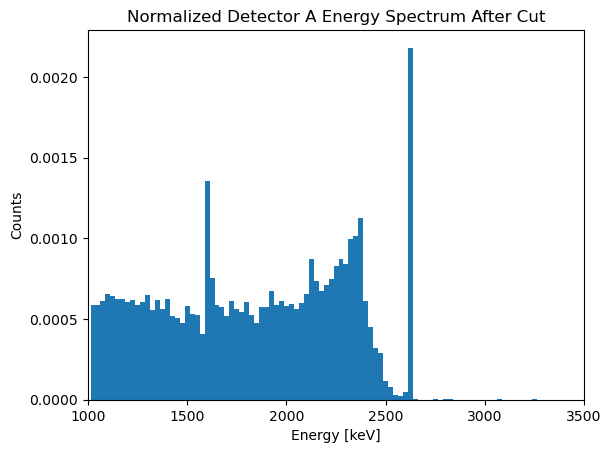

In [20]:
counts_A, bin_edges_A = np.histogram(data_A_with_cut['energy'], bins=100, range=(1000, 3500))
bin_width_A = (bin_edges_A[-1] - bin_edges_A[0]) / 100
normalized_counts_A = counts_A/(np.sum(counts_A)*bin_width_A)
bin_centers_A = 0.5 * (bin_edges_A[1:] + bin_edges_A[:-1])
# print(bin_centers_A)
plt.bar(bin_edges_A[1:], normalized_counts_A, width=bin_width_A)
plt.xlim(1000, 3500)
plt.xlabel("Energy [keV]")
plt.ylabel("Counts")
plt.title("Normalized Detector A Energy Spectrum After Cut")
plt.show()

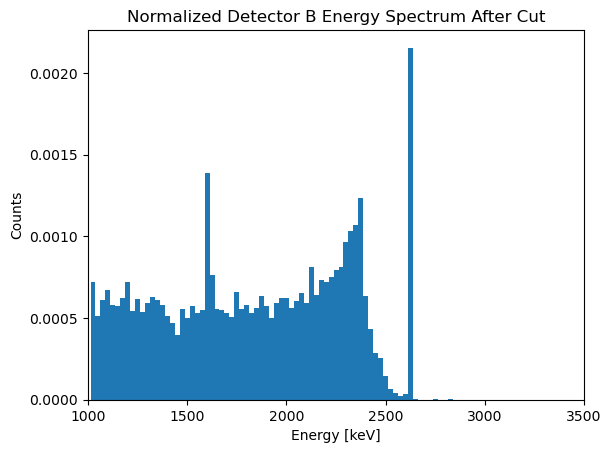

In [21]:
counts_B, bin_edges_B = np.histogram(data_B_with_cut['energy'], bins=100, range=(1000, 3500))
bin_width_B = (bin_edges_B[-1] - bin_edges_B[0]) / 100
normalized_counts_B = counts_B/(np.sum(counts_B)*bin_width_B)
bin_centers_B = 0.5 * (bin_edges_B[1:] + bin_edges_B[:-1])
plt.bar(bin_edges_B[1:], normalized_counts_B, width=bin_width_B)
plt.xlabel("Energy [keV]")
plt.ylabel("Counts")
plt.title("Normalized Detector B Energy Spectrum After Cut")
# print(bin_centers_B)
plt.xlim(1000, 3500)
plt.show()

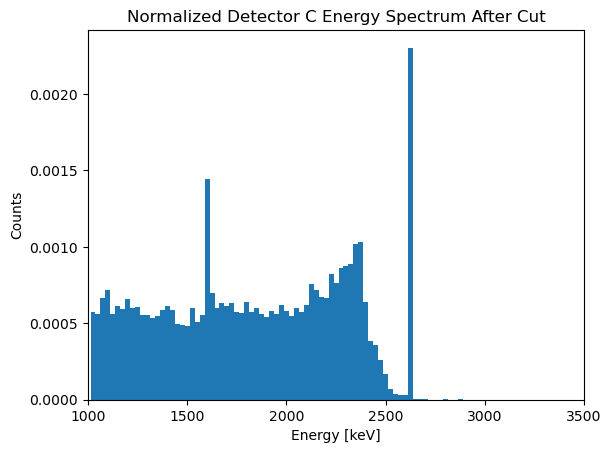

In [22]:
counts_C, bin_edges_C = np.histogram(data_C_with_cut['energy'], bins=100,range=(1000, 3500))
bin_width_C = (bin_edges_C[-1] - bin_edges_C[0]) / 100
normalized_counts_C = counts_C/(np.sum(counts_C)*bin_width_C)
bin_centers_C = 0.5 * (bin_edges_C[1:] + bin_edges_C[:-1])
plt.bar(bin_edges_C[1:], normalized_counts_C, width=bin_width_C)
plt.xlabel("Energy [keV]")
plt.ylabel("Counts")
plt.title("Normalized Detector C Energy Spectrum After Cut")
plt.xlim(1000, 3500)
plt.show()

In [23]:
from scipy.integrate import quad, quad_vec, simpson
from scipy.interpolate import interp1d

def new_fit(bin_centers, total_counts, thetaA, thetaB, thetaC, thetaNLDBD):
    # thetaA = 1350
    # thetaB = 770
    # return thetaA*normalized_counts_A + thetaB*normalized_counts_B + thetaC*normalized_counts_C + thetaNLDBD*nldbd_pdf(bin_centers)
    combined_pdf = (
        thetaA * normalized_counts_A +
        thetaB * normalized_counts_B +
        thetaC * normalized_counts_C +
        thetaNLDBD * nldbd_pdf(bin_centers)
    )

    return combined_pdf

    # interpolate to create a callable function
    # combined_pdf_func = interp1d(bin_centers, combined_pdf, kind='linear', fill_value="extrapolate")

    #compute the normalization factor using quad to integrate
    norm_factor = np.trapz(combined_pdf, bin_centers)
    # norm_factor = simpson(combined_pdf, x=bin_centers)
 

    #normalize the final sum
    # normalized_combined_pdf = combined_pdf / norm_factor

    # expected_counts = total_counts*normalized_combined_pdf

    # return expected_counts

In [84]:
counts, bin_edges = np.histogram(data_Target_with_cut['energy'], bins=100, range=(1000,3500)) 
bin_width = (bin_edges[-1] - bin_edges[0]) / 100
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

#calculate normalized counts of detector target to fit to normalized pdf 
normalized_counts = counts/(np.sum(counts))
total_counts = np.sum(counts)

def new_fit(bin_centers, thetaA, thetaB, thetaC, thetaNLDBD):
    combined_pdf = (
        thetaA * normalized_counts_A +
        thetaB * normalized_counts_B +
        thetaC * normalized_counts_C +
        thetaNLDBD * nldbd_pdf(bin_centers)
    )

    norm_factor = np.trapz(combined_pdf, bin_centers)
 
    normalized_combined_pdf = combined_pdf / norm_factor

    expected_counts = total_counts*bin_width*normalized_combined_pdf

    return expected_counts

def chi2(thetaA, thetaB, thetaC, thetaNLDBD):
    expected = new_fit(bin_centers, thetaA, thetaB, thetaC, thetaNLDBD) 
    uncert = np.abs(expected)
    # actual = normalized_counts
    actual= counts
    mask = expected > 0
    chi2_value = np.sum(((actual[mask] - expected[mask]) ** 2) / expected[mask])
    #independent measurements 
    chi2_value += ((thetaA-1350)**2)/(100**2) 
    chi2_value += ((thetaB-770)**2)/(270**2)
    #decorrelation terms to prevent the parameters from becoming too degenerate since the detector pdfs are the same shape
    delta = 500
    
    chi2_value += ((thetaC - thetaA)**2) / delta**2
    chi2_value += ((thetaC - thetaB)**2) / delta**2
    chi2_value += ((thetaA - thetaB)**2) / delta**2
    # delta_C_signal = 500  

    # chi2_value += ((thetaC - thetaNLDBD) ** 2) / delta_C_signal**2
    return chi2_value 

minuit = Minuit(chi2, thetaA=1350, thetaB=770, thetaC=1000, thetaNLDBD=50)
minuit.limits = [(0, None)]*4
minuit.errordef = Minuit.LEAST_SQUARES
minuit.migrad()

best_fit_thetaA = minuit.values["thetaA"]
best_fit_thetaB = minuit.values["thetaB"]
best_fit_thetaC = minuit.values["thetaC"]

best_fit_thetaNLDBD = minuit.values["thetaNLDBD"]

print(f"Best-fit thetaC: {best_fit_thetaC:.2f}")
print(f"Best-fit thetaNLDBD: {best_fit_thetaNLDBD:.2f}")
print(f"Best-fit thetaA: {best_fit_thetaA:.2f}")
print(f"Best-fit thetaB: {best_fit_thetaB:.2f}")

chi2_min = minuit.fval

print (f"Best-fit chi-square: {chi2_min:.2f}")
ndof = np.sum(counts > 0) - minuit.nfit  # Number of degrees of freedom is number of bins (with data) - number of free parameters
print(f"Best-fit reduced chi2 = {chi2_min:.2f} / {ndof} = {chi2_min/ndof:.2f}")


Best-fit thetaC: 1188.75
Best-fit thetaNLDBD: 4.63
Best-fit thetaA: 1329.72
Best-fit thetaB: 521.30
Best-fit chi-square: 440.19
Best-fit reduced chi2 = 440.19 / 65 = 6.77


In [83]:
#check normalization is correct
print(np.trapz(normalized_counts_A, bin_centers))
print(np.trapz(normalized_counts_B, bin_centers))
print(np.trapz(normalized_counts_C, bin_centers))
print(np.trapz(nldbd_pdf(bin_centers), bin_centers))

0.992654740141029
0.990996595075956
0.9928268142048379
1.0


In [38]:
print(minuit.covariance)  # Shows variances and covariances
print(minuit.covariance.correlation())  # Shows correlation coefficients

┌────────────┬─────────────────────────────────────────────┐
│            │     thetaA     thetaB     thetaC thetaNLDBD │
├────────────┼─────────────────────────────────────────────┤
│     thetaA │   9.64e+03        3e3        5e3      0.5e3 │
│     thetaB │        3e3   5.36e+04     0.02e6      2.4e3 │
│     thetaC │        5e3     0.02e6   1.14e+05      4.0e3 │
│ thetaNLDBD │      0.5e3      2.4e3      4.0e3        896 │
└────────────┴─────────────────────────────────────────────┘
┌────────────┬─────────────────────────────────────────────┐
│            │     thetaA     thetaB     thetaC thetaNLDBD │
├────────────┼─────────────────────────────────────────────┤
│     thetaA │          1        0.1        0.2        0.2 │
│     thetaB │        0.1          1        0.3        0.3 │
│     thetaC │        0.2        0.3          1        0.4 │
│ thetaNLDBD │        0.2        0.3        0.4          1 │
└────────────┴─────────────────────────────────────────────┘


In [39]:
for param in ["thetaA", "thetaB", "thetaC"]:
    prior = {"thetaA": 1350, "thetaB": 770, "thetaC": 2000}[param]
    sigma = {"thetaA": 100, "thetaB": 270, "thetaC": 1000}[param]
    pull = (minuit.values[param] - prior) / sigma
    print(f"{param} pull = {pull:.2f}σ")

thetaA pull = -0.26σ
thetaB pull = 0.41σ
thetaC pull = -0.56σ


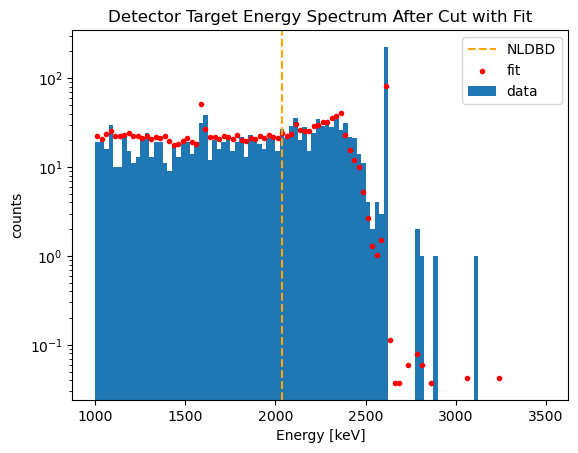

In [111]:

plt.axvline(x=2039, color="orange", linestyle="dashed", label="NLDBD")
plt.bar(bin_centers, counts, width=bin_width, label="data")
plt.scatter(bin_centers,new_fit(bin_centers, best_fit_thetaA, best_fit_thetaB, best_fit_thetaC, best_fit_thetaNLDBD), color='red',marker='.', label="fit")
plt.legend()
plt.title("Detector Target Energy Spectrum After Cut with Fit")
plt.xlabel("Energy [keV]")
plt.ylabel("counts")
plt.yscale('log')
# plt.ylim(1, 200)
plt.show()

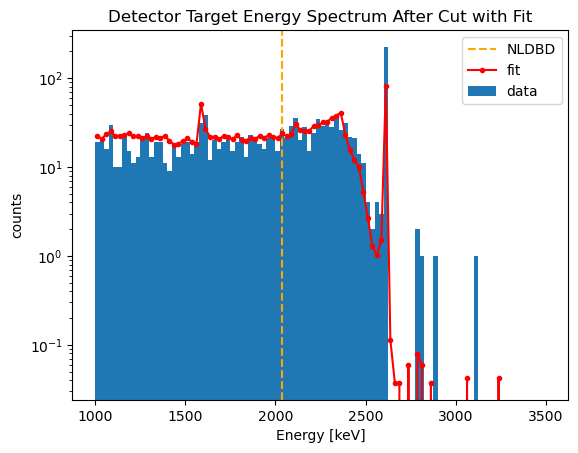

In [114]:
plt.axvline(x=2039, color="orange", linestyle="dashed", label="NLDBD")
plt.bar(bin_centers, counts, width=bin_width, label="data")
plt.plot(bin_centers,new_fit(bin_centers, best_fit_thetaA, best_fit_thetaB, best_fit_thetaC, best_fit_thetaNLDBD), color='red',marker='.', label="fit")
plt.legend()
plt.title("Detector Target Energy Spectrum After Cut with Fit")
plt.xlabel("Energy [keV]")
plt.ylabel("counts")
plt.yscale('log')
# plt.ylim(1, 200)
plt.show()

In [86]:
m=best_fit_thetaNLDBD/cut_eff #number of NLDBD
print(m)

6.022023216056513


Step 7: 90% Confidence Limit

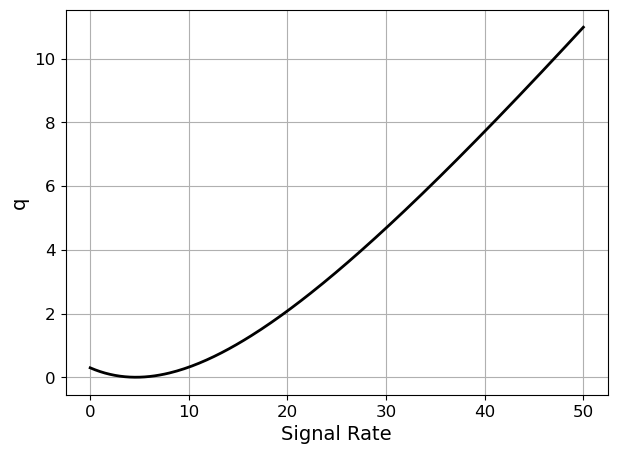

In [89]:
thetaNLDBD_scan = np.linspace(0, 50, 200)  # Test range of signal strengths
q_values = []

for theta in thetaNLDBD_scan:
    m_fixed = Minuit(lambda thetaA, thetaB, thetaC : chi2(thetaA, thetaB, thetaC, theta),thetaA=1350, thetaB=770, thetaC=1000)
    m_fixed.limits = [(0, None)] * 3
    m_fixed.errordef = Minuit.LEAST_SQUARES
    m_fixed.migrad()
    # m_fixed.simplex()
    if not m_fixed.valid:
        print(f"Warning: Fit failed for theta = {theta}")
    chi2_fixed = m_fixed.fval
    # print(chi2_fixed)
    
    # Calculate q for this signal rate
    q = chi2_fixed-chi2_min
    # print(chi2_fixed, chi2_min, theta)
    q_values.append(q)

# Plot q vs. signal rate
plt.figure(figsize=(7, 5))
plt.plot(thetaNLDBD_scan, q_values, color='black', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Signal Rate", fontsize=14)
plt.ylabel("q", fontsize=14)
plt.grid()
plt.show()

In [90]:
closest_diff = float('inf')
closest_rate = float('inf')
for i in range(len(thetaNLDBD_scan)):
    if abs(q_values[i]-2.71) < closest_diff and thetaNLDBD_scan[i]>best_fit_thetaNLDBD: # Note that the upperlimit has to be greater than S_best-fit
        closest_diff = abs(q_values[i]-2.71)
        closest_rate = thetaNLDBD_scan[i]

In [91]:
print (f"Upper-limit on Signal Rate: {closest_rate:.2f}")

Upper-limit on Signal Rate: 22.61


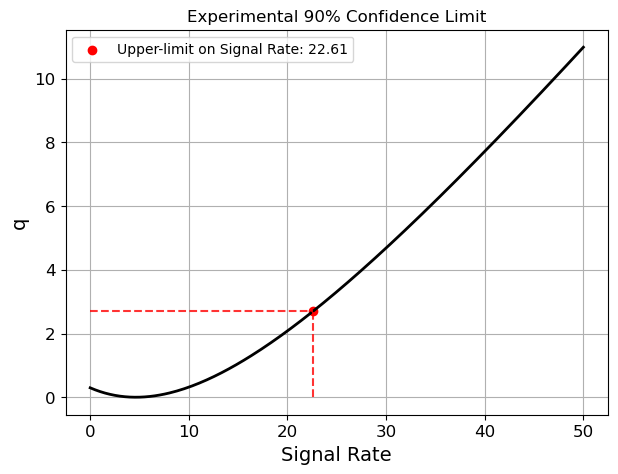

In [110]:
plt.figure(figsize=(7, 5))
plt.plot(thetaNLDBD_scan, q_values, color='black', linewidth=2)
plt.hlines(2.71, 0, closest_rate, linestyle='--', color='red', alpha=0.8)
plt.vlines(closest_rate, 0, 2.71, linestyle='--', color='red', alpha=0.8)
plt.scatter(22.61, 2.71, label=f"Upper-limit on Signal Rate: {closest_rate:.2f}", color='red')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Signal Rate", fontsize=14)
plt.ylabel("q", fontsize=14)
plt.title("Experimental 90% Confidence Limit")
plt.legend()
plt.grid()
plt.show()

In [93]:
# import multiprocessing as mp
from tqdm import tqdm

In [95]:
import statistics
    
def chi2_fake(thetaA, thetaB, thetaC, thetaNLDBD):
    expected = new_fit(bin_centers, thetaA, thetaB, thetaC, thetaNLDBD)
    uncert = np.abs(expected)
    actual= fake_data
    mask = expected > 0
    chi2_value = np.sum(((actual[mask] - expected[mask]) ** 2) / expected[mask])
    #independent measurements
    chi2_value += ((thetaA-1350)**2)/(100**2) 
    chi2_value += ((thetaB-770)**2)/(270**2)
    #decorrelation terms
    delta = 500
        
    chi2_value += ((thetaC - thetaA)**2) / delta**2
    chi2_value += ((thetaC - thetaB)**2) / delta**2
    chi2_value += ((thetaA - thetaB)**2) / delta**2
         
    return chi2_value
    


def find_90_conf_lim():
    
    m= Minuit(chi2_fake, thetaA=1350, thetaB=770, thetaC=1000, thetaNLDBD=50)
    m.limits = [(0, None)]*4
    m.migrad()
    # minuit.simplex()
    best_fit_thetaA = m.values["thetaA"]
    best_fit_thetaB = m.values["thetaB"]
    best_fit_thetaC = m.values["thetaC"]
    
    best_fit_thetaNLDBD = m.values["thetaNLDBD"]
    chi2_min = m.fval
    # print(chi2_min)

    thetaNLDBD_scan = np.linspace(0, 50, 200)  # Test range of signal strengths
    q_values = []
    
    for theta in thetaNLDBD_scan:
        m_fixed = Minuit(lambda thetaA, thetaB, thetaC : chi2_fake(thetaA, thetaB, thetaC, theta),thetaA=1350, thetaB=770, thetaC=1000)
        m_fixed.limits = [(0, None)] * 3
        m_fixed.migrad()
        # m_fixed.simplex()
        if not m_fixed.valid:
            print(f"Warning: Fit failed for theta = {theta}")
        chi2_fixed = m_fixed.fval
    
        q = chi2_fixed-chi2_min
        # print(chi2_fixed, chi2_min, theta)
        q_values.append(q)

    closest_diff = float('inf')
    closest_rate = float('inf')
    for i in range(len(thetaNLDBD_scan)):
        if abs(q_values[i]-2.71) < closest_diff and thetaNLDBD_scan[i]>best_fit_thetaNLDBD: # Note that the upperlimit has to be greater than S_best-fit
            closest_diff = abs(q_values[i]-2.71)
            closest_rate = thetaNLDBD_scan[i]
    return closest_rate

def run_conf_lim(fake_data):
    return find_90_conf_lim(fake_data)

    
background = new_fit(bin_centers, best_fit_thetaA, best_fit_thetaB, best_fit_thetaC, 0)
limits = []
n_limits = 500

# for j in range(n_limits):
#     fake_data = np.random.poisson(background)
#     rate=find_90_conf_lim()
#     print(rate)
#     limits.append(rate)

for _ in tqdm(range(n_limits), desc="Running"):
    fake_data = np.random.poisson(background)
    limit = find_90_conf_lim()
    limits.append(limit)
            
print(f"{n_limits} Median 90% Confidence Limit: ", statistics.median(limits))

Running: 100%|██████████| 500/500 [19:47<00:00,  2.38s/it]

500 Median 90% Confidence Limit:  19.346733668341706


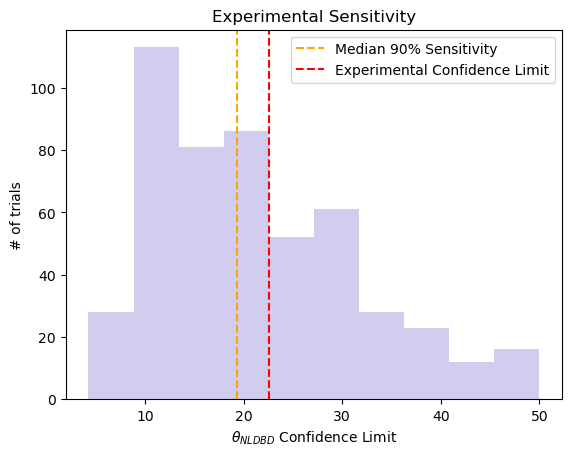

In [106]:
plt.hist(limits, alpha=.3, color='slateblue')
plt.axvline(x=statistics.median(limits), color="orange", linestyle="dashed", label="Median 90% Sensitivity")
plt.axvline(x=closest_rate, color="red", linestyle="dashed", label="Experimental Confidence Limit")
plt.xlabel(r"$\theta_{NLDBD}$ Confidence Limit")
plt.ylabel("# of trials")
plt.title("Experimental Sensitivity")
plt.legend()
plt.show()